In [10]:
import numpy as np
import matplotlib.pyplot as plt
import napari

In [11]:
from tifffile import imread

In [12]:
viewer = napari.Viewer()

In [13]:
#plane = imread('/tungstenfs/scratch/gfriedri/montruth/CLEM_Analyses/CLEM_20220426_RM0008_130hpf_fP1_f3/pycpd/plane4_Ala_first_half.tif')
#load lm plane image
plane = np.flip(imread(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\results\anatomy\plane01\anatomy_binned_x1y1z1_20220426_RM0008_130hpf_fP1_f3_t1_o1Ala_001_.tif"),axis=1)
plane= plane.astype(np.uint16)[plane.shape[0]//2:]





In [14]:
#stack = imread('/tungstenfs/scratch/gfriedri/montruth/CLEM_Analyses/CLEM_20220426_RM0008_130hpf_fP1_f3/pycpd/lm_stack.tif')
#load lm stack image
stack  = imread(r"\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\CLEM_Analyses\CLEM_20220426_RM0008_130hpf_fP1_f3\pycpd\lm_stack.tif")


In [15]:
plane.shape

(256, 512)

In [16]:
stack.shape

(375, 512, 512)

In [17]:
viewer.add_image(stack)

<Image layer 'stack' at 0x2190ad2cdf0>

In [18]:
from skimage.transform import SimilarityTransform

In [19]:
transformation = SimilarityTransform(np.array(
    [[ 1.06932423e+00, -9.88353099e-02, -1.57206100e-02,  4.83865881e+01],

     [ 9.88090846e-02,  1.06943927e+00, -2.50709394e-03,  1.36403526e+02],

     [ 1.58846112e-02,  1.04986984e-03,  1.07387916e+00, -2.65635800e+01],

     [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]
))

In [20]:
# Thickness of target stack + 2
thickness = 7

In [21]:
t_2 = thickness // 2
zz, yy, xx = np.meshgrid(
    np.linspace(-t_2, t_2+1, num=int(thickness*transformation.scale) + 1, endpoint=False), 
    np.linspace(0, plane.shape[0], num=int(transformation.scale * plane.shape[0]) + 1, endpoint=False),
    np.linspace(0, plane.shape[1], num=int(transformation.scale * plane.shape[1]) + 1, endpoint=False),
    indexing='ij'
)
# plane coordinates +/- half thickness e.g. -3, -2, -1, 0, 1, 2, 3 in Z
plane_coords = np.stack([zz.flatten(), yy.flatten(), xx.flatten()], axis=1)

In [22]:
zz.shape

(8, 275, 550)

In [23]:
# These are the target stack coordinates in the overview stack.
# They are real numbers.
plane_coords_in_stack = transformation(plane_coords)

In [24]:
plane_coords_in_stack

array([[ 45.17861541, 136.10709875, -26.61123383],
       [ 45.16398095, 136.10476487, -25.61154996],
       [ 45.14934649, 136.10243099, -24.61186609],
       ...,
       [ 18.51334473, 408.2165763 , 520.58092706],
       [ 18.49871027, 408.21424243, 521.58061093],
       [ 18.48407581, 408.21190855, 522.5802948 ]])

In [25]:
# viewer.add_points(plane_coords_in_stack, size=3, opacity=0.2)

In [26]:
# Round target stack coordinates to integer grid.
plane_stack_source_coordinates = np.round(plane_coords_in_stack).astype(np.int16)

In [27]:
# viewer.add_points(int_plane_coords_in_stack, size=3, opacity=0.2)

In [28]:
plane_stack_source_coordinates

array([[ 45, 136, -27],
       [ 45, 136, -26],
       [ 45, 136, -25],
       ...,
       [ 19, 408, 521],
       [ 18, 408, 522],
       [ 18, 408, 523]], dtype=int16)

In [29]:
plane_stack_source_coordinates.shape

(1210000, 3)

In [30]:
# Remove coordinates outside of the overview stack
valid_coords = plane_stack_source_coordinates[np.all(plane_stack_source_coordinates >= 0, axis=1)]
valid_coords = valid_coords[np.all(valid_coords < stack.shape, axis=1)]

In [31]:
valid_coords.shape

(1127711, 3)

In [32]:
# Convert coordinates into index which works on the flattened stack.
idx = np.ravel_multi_index((valid_coords[:, 0], valid_coords[:, 1], valid_coords[:, 2]), stack.shape)

In [33]:
# Create empty flat stack
tmp = np.zeros_like(stack).flatten()

In [34]:
# Copy values from flattened stack into empty flat stack.
# These values are the ones which are +/- half-thickness around the plane of interest.
tmp[idx] = stack.flatten()[idx]

In [35]:
tmp.shape = stack.shape

In [36]:
viewer.add_image(tmp)

<Image layer 'tmp' at 0x21913b22040>

In [37]:
from scipy.interpolate import griddata

In [38]:
?griddata

Signature:
griddata(
    points,
    values,
    xi,
    method='linear',
    fill_value=nan,
    rescale=False,
)
Docstring:
Interpolate unstructured D-D data.

Parameters
----------
points : 2-D ndarray of floats with shape (n, D), or length D tuple of 1-D ndarrays with shape (n,).
    Data point coordinates.
values : ndarray of float or complex, shape (n,)
    Data values.
xi : 2-D ndarray of floats with shape (m, D), or length D tuple of ndarrays broadcastable to the same shape.
    Points at which to interpolate data.
method : {'linear', 'nearest', 'cubic'}, optional
    Method of interpolation. One of

    ``nearest``
      return the value at the data point closest to
      the point of interpolation. See `NearestNDInterpolator` for
      more details.

    ``linear``
      tessellate the input point set to N-D
      simplices, and interpolate linearly on each simplex. See
      `LinearNDInterpolator` for more details.

    ``cubic`` (1-D)
      return the value determined from 

In [39]:
# Get coordinates for target stack (thicknes -2 (-1 on both sides of z))
zz, yy, xx = np.meshgrid(
    range(-t_2 + 1, t_2), range(plane.shape[0]), range(plane.shape[1]), indexing='ij'
)
xi = transformation(np.stack([zz.flatten(), yy.flatten(), xx.flatten()], axis=1))

In [40]:
zz.shape

(5, 256, 512)

In [41]:
# Get interpolated target stack
interpolated_plane = griddata(
    points=valid_coords,
    values=stack.flatten()[idx],
    xi=xi,
    method='nearest'
).reshape(zz.shape)

In [42]:
# 2 channel image with original plane in 2nd channel in the center z-plane
both = np.zeros((2,) + interpolated_plane.shape, dtype=interpolated_plane.dtype)

both[0] = interpolated_plane
both[1, interpolated_plane.shape[0]//2] = plane

In [55]:
viewer.add_image(both, channel_axis=0,contrast_limits = [0,5000])

[<Image layer 'Image' at 0x21909a02e20>,
 <Image layer 'Image [1]' at 0x2190a3a4880>]

In [44]:
# naive interpolation by simply flooring coordinates. No griddata interpolation.
xi = xi.astype(np.uint16)

In [45]:
valid_xi = np.logical_and(np.all(xi >= 0, axis=1), np.all(xi < stack.shape, axis=1))

In [46]:
valid_xi.sum()

611840

In [47]:
interpolation_idx = np.ravel_multi_index((xi[valid_xi, 0], xi[valid_xi, 1], xi[valid_xi,2]), stack.shape)

In [48]:
interpolation_idx

array([11866112, 11866112, 11866113, ...,  4665853,  4665854,  4665855],
      dtype=int64)

In [49]:
stack_plane = np.zeros_like(zz, dtype=stack.dtype).flatten()

In [50]:
stack_plane[valid_xi] = stack.flatten()[interpolation_idx]

In [51]:
stack_plane.shape

(655360,)

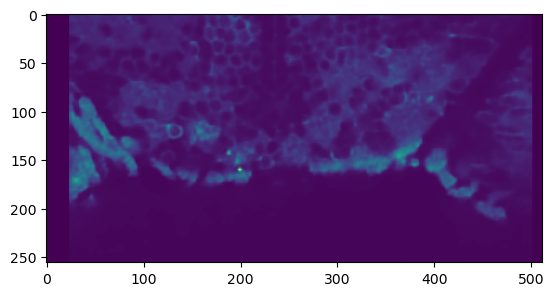

In [52]:
plt.imshow(stack_plane.reshape(zz.shape)[zz.shape[0]//2])